In [22]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
import json
from multiprocessing import Pool
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

# About this Notebook

**Objectives :** 
1. Read scattergrams
2. Isolate platelets
5. Export

Scattergrams (SCT) from the PFC and INTERVAL cohorts are not loaded together. For some reason, I called items from the PFC cohort with the prefix `sys`, while `pfc` would surely have been better...

# Sysmex SCT

For illustration, we show here what raw scattergrams look like : they have an important cloud of red blood cells (RBC) at the bottom left. It is important that **the version we actually keep has no RBC**. 

648 candidates Sysmex WB files
Two files for ID C18PNK
	 Sysmex whole blood/October 2017/11112017/10112017_C18PNK/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][10112017_103414][C18PNKFB][PLT-F].fcs
	 Sysmex whole blood/November 2017/10112017/10112017_C18PNK/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][10112017_103414][C18PNKFB][PLT-F].fcs
Two files for ID C18PPG
	 Sysmex whole blood/October 2017/11112017/10112017_C18PPG/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][10112017_120048][C18PPGFB][PLT-F].fcs
	 Sysmex whole blood/November 2017/10112017/10112017_C18PPG/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][10112017_120048][C18PPGFB][PLT-F].fcs
Two files for ID C18JSY
	 Sysmex whole blood/October 2017/02102017_C18JSY/02102017_positive/02102017_C18JSY/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][02102017_092024][C18JSYFB][PLT-F].fcs
	 Sysmex whole blood/October 2017/02102017_C18JSY/FCS/[XN-20^12829][00-22A (Build 7)][Fcs][02102017_093246][C18JSYFB][PLT-F].fcs
Two files for ID C18JSY
	 Sysmex whole blood/Octobe

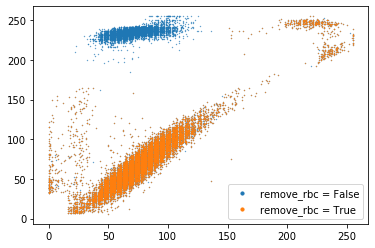

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
for remove_rbc in [False, True]:
    sys_sct_raw = load_Sysmex(data_dir,remove_rbc=remove_rbc)
    sys_sct_raw.rename(columns={"Side Fluorescence Signal":"SFL",
                                      "Forward Scatter Signal":"FSC",
                                      "Forward Scatter Pulse Width Signal":"FSCW",
                                      "Side Scatter Signal":"SSC"},inplace=True)
    sys_sct = sys_sct_raw[["ID"] + FACS_COLS].copy()
    sys_sct[FACS_COLS] = sys_sct[FACS_COLS].astype(int)
    
    example = sys_sct.loc[sys_sct.ID == "C0X5MT"]
    
    plt.scatter(example["SFL"],example["FSC"],s=.1, label="remove_rbc = %s" % remove_rbc)
plt.legend(markerscale=10);

# INTERVAL SCT

We find all scattergrams to read and check that they correspond to an ID we can match

In [18]:
sysmex_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_HAAS"
files = glob("%s/*/SCT/PLTF*.csv" % sysmex_dir)
int_phen = pd.read_csv("%s/processed/interval_instrument_filename.csv" % data_dir)

In [19]:
to_read = [[sysmex_dir + "/" + m + "/SCT/PLTF_" + f +".csv" for f in \
           int_phen.loc[int_phen.FileName.str.contains(m,regex=False),"FileName"].tolist()] \
               for m in int_phen.Instrument.unique().tolist()]
to_read = to_read[0] + to_read[1]

print("Found %d scattergrams to read" % len(to_read))

Found 30725 scattergrams to read


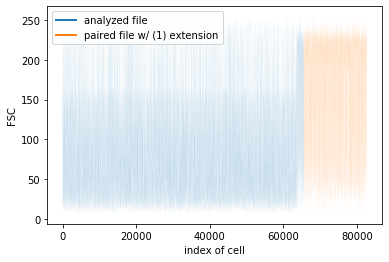

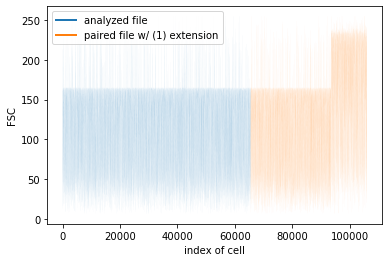

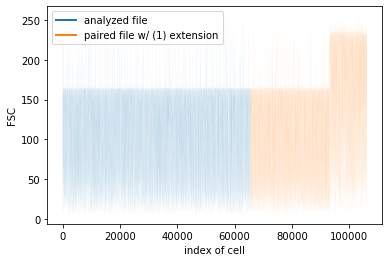

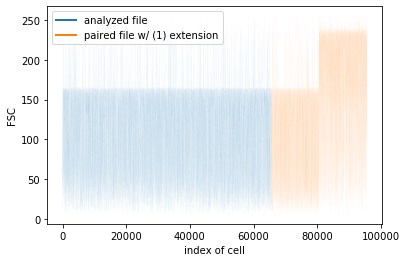

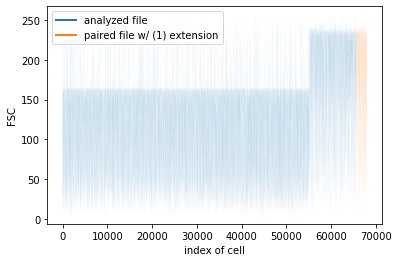

In [20]:
# We look briefly at what happens with files for which we do not study the duplicate.
# -> We simply miss some platelets
count = 0
for f in glob("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_HAAS/XN-10^11036/SCT/*"):
    
    if "PLTF" in f and "(1)" in f:
        count += 1
        if count <= 5:
            sct_2 = pd.read_csv(f)
            sct_1 = pd.read_csv("".join(f.split("(1)")))
            plt.figure()
            plt.plot(sct_1["FSC"],lw=.01,label="analyzed file")
            plt.plot(np.arange(sct_1.shape[0],sct_1.shape[0]+sct_2.shape[0]),sct_2["FSC"],lw=.01,label="paired file w/ (1) extension")
            plt.ylabel("FSC")
            plt.xlabel("index of cell")
            leg = plt.legend()
            # get the individual lines inside legend and set line width
            for line in leg.get_lines():
                line.set_linewidth(2)

In [21]:
# Get IDs from file names
IDs = [f.split("][")[-1].lstrip(' ').split("]")[0] for f in to_read]
# One file per ID
assert len(IDs) == len(list(set(IDs)))

In the INTERVAL cohort, it's easier to spot the RBC cloud because it's marked as Phase B data.

In [23]:
delete_rbc = True

def read_sct(f):
    sct = pd.read_csv(f,usecols=FACS_COLS+ ["Phase"])
    assert sct.shape[0] > 0
    ID = f.split("][")[-1].lstrip(' ').split("]")[0]
    if delete_rbc:
        sct = sct.loc[sct.Phase == "A"]
        #sct["bin_200"] = np.arange(sct.shape[0]) // 200
        #mean_by_200 = sct.groupby("bin_200")["FSC"].mean()
        #try:
        #    cutoff = np.min(
        #        np.where(mean_by_200 > np.mean(mean_by_200[:3])+30)[0])
        #except ValueError as e:
        #    cutoff = sct["bin_200"].max()
        #sct = sct.loc[sct.bin_200 < cutoff]
        #del sct["bin_200"]
    #sct[FACS_COLS] = sct[FACS_COLS].astype(int)
    #sct = sct[FACS_COLS].astype(int)
    sct["ID"] = ID
    return sct

In [24]:
p = Pool(15)

In [25]:
dfs = []
# Only load a few examples, to check that clusterng will work well.
#to_read = np.random.choice(to_read,1000,replace=False)
for sct in tqdm(p.imap_unordered(read_sct, np.random.choice(to_read,len(to_read),replace=False)),total=len(to_read)):
    dfs.append(sct)
p.close()
p.join()

100%|██████████| 30725/30725 [02:20<00:00, 218.90it/s]


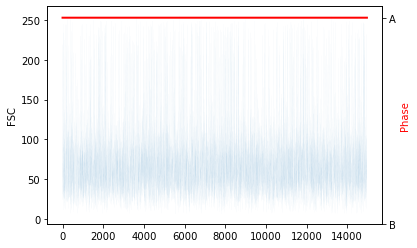

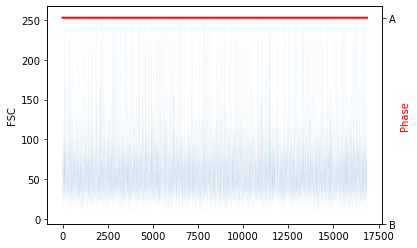

In [26]:
for df in dfs[:2]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df.FSC,lw=.01)
    ax.set_ylabel("FSC")
    ax = ax.twinx()
    ax.plot((df.Phase == "A"),lw=2,c="red")
    ax.set_yticks([0,1])
    ax.set_yticklabels(["B","A"])
    ax.set_ylabel("Phase",color="red")
    plt.xlabel("# Cell measured")

In [27]:
int_sct = pd.concat(dfs,axis=0,ignore_index=True).reset_index()

In [28]:
print(int_sct.ID.value_counts().mean())
print(int_sct.ID.value_counts().std())

21331.948771358828
4713.469968067051


Text(0, 0.5, 'Donors')

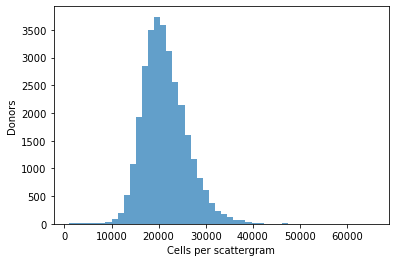

In [29]:
plt.hist(int_sct.ID.value_counts(),bins=50,alpha=.7);
plt.xlabel("Cells per scattergram")
plt.ylabel("Donors");

# Filter platelets

We isolate platelets using two 2D gates : one in the SFLxFSC plane and the other in the SFLxSSC plane. The first one is the same for all instruments, and there are three variants of the second one, depending on the instrument of origin.

In [53]:
# We subsample for plotting so that it does not take ages
sub_int_sct = int_sct.sample(int(1e5))
sub_int_sct = pd.merge(sub_int_sct,int_phen[["SampleNo","Instrument"]],left_on="ID",right_on="SampleNo",how="left")
sub_cond_36 = sub_int_sct.Instrument.str.contains("36")
sub_sys_sct = sys_sct.sample(int(1e5))

In [31]:
def polygon_sfl_fsc_with_offset(offset):
    alpha = ((120+.6*offset) - (25+ .5*offset)) / (85 - 25)
    
    p = np.array([[22,25,30,85 ,140,200,200,80,50,22],
                  [5 + .3*offset ,25+ .5*offset,max(35+.5*offset,25+.5*offset + alpha*5),120+.6*offset,180+.6*offset,220,160,15,0,5+ .3*offset]])
    p[0,5:-1] += 10
    #p[0] -= offset
    return p.T

In [34]:
def polygon_sfl_ssc(inst = "PFC"):
    if inst == "41":
        return np.array([[15,15,125,190,190,100,15],[5,45,125,130,50,5,5]]).T
    elif inst == "36":
        return np.array([[20,20,125,190,190,100,20],[5,35,115,120,50,5,5]]).T
    elif inst == "PFC":
        return np.array([[25,25,50,125,190,190,100,25],[5,30,65,120,125,50,5,5]]).T
    else:
        raise "Not known %s" % inst

In [74]:
offset = 10
path_sfl_fsc = mplPath.Path(polygon_sfl_fsc_with_offset(offset))

path_36 = mplPath.Path(polygon_sfl_ssc("36"))
path_41 = mplPath.Path(polygon_sfl_ssc("41"))
path_pfc = mplPath.Path(polygon_sfl_ssc("PFC"))

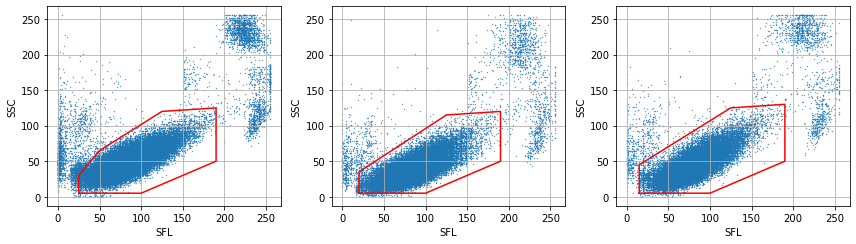

In [75]:
# Three slightly different SFL/SSC gates
fig = plt.figure(figsize=(12,3.5))

ax = fig.add_subplot(131)
ax.scatter(sub_sys_sct["SFL"],sub_sys_sct["SSC"],s=.1)
ax.plot(path_pfc._vertices[:,0],path_pfc._vertices[:,1],label="PFC",c="red")
plt.xlabel("SFL")
plt.ylabel("SSC")
plt.grid(True)
ax = fig.add_subplot(132)
ax.scatter(sub_int_sct.loc[sub_cond_36,"SFL"],sub_int_sct.loc[sub_cond_36,"SSC"],s=.1)
plt.plot(path_36._vertices[:,0],path_36._vertices[:,1],label="INTERVAL Instrument *36",c="red")
plt.xlabel("SFL")
plt.ylabel("SSC")
plt.grid(True)
ax = fig.add_subplot(133)
ax.scatter(sub_int_sct.loc[~sub_cond_36,"SFL"],sub_int_sct.loc[~sub_cond_36,"SSC"],s=.1)
plt.plot(path_41._vertices[:,0],path_41._vertices[:,1],label="INTERVAL Instrument *41",c="red")
plt.xlabel("SFL")
plt.ylabel("SSC")
plt.grid(True)
plt.tight_layout()

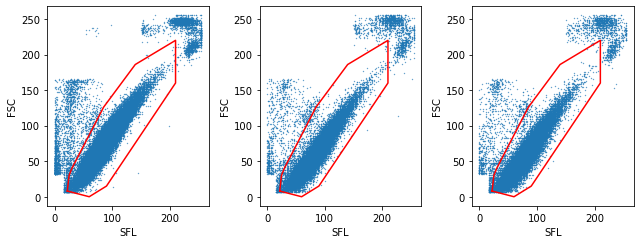

In [66]:
# An unique SFL/FSC gate
fig = plt.figure(figsize=(9,3.5))
ax = fig.add_subplot(131)
ax.scatter(sub_sys_sct["SFL"],sub_sys_sct["FSC"],s=.1)
ax.plot(path_sfl_fsc._vertices[:,0],path_sfl_fsc._vertices[:,1],label="PFC",c="red")
plt.xlabel("SFL")
plt.ylabel("FSC")
ax = fig.add_subplot(132)
ax.scatter(sub_int_sct.loc[sub_cond_36,"SFL"],sub_int_sct.loc[sub_cond_36,"FSC"],s=.1)
plt.plot(path_sfl_fsc._vertices[:,0],path_sfl_fsc._vertices[:,1],label="INTERVAL Instrument *36",c="red")
plt.xlabel("SFL")
plt.ylabel("FSC")
ax = fig.add_subplot(133)
ax.scatter(sub_int_sct.loc[~sub_cond_36,"SFL"],sub_int_sct.loc[~sub_cond_36,"FSC"],s=.1)
plt.plot(path_sfl_fsc._vertices[:,0],path_sfl_fsc._vertices[:,1],label="INTERVAL Instrument *41",c="red")
plt.xlabel("SFL")
plt.ylabel("FSC")
plt.tight_layout()

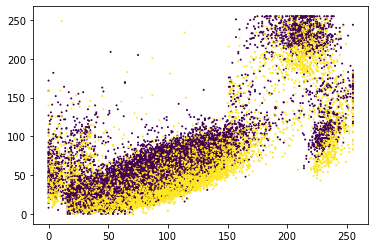

In [68]:
# Motivation for using differens SFL_SSC gates
plt.scatter(sub_int_sct.SFL, sub_int_sct.SSC,c=sub_int_sct.Instrument.str.contains("36"),s=1)

In [72]:
int_41_IDs = int_phen.loc[int_phen.Instrument.str.contains("41")].SampleNo.tolist()
int_36_IDs = int_phen.loc[int_phen.Instrument.str.contains("36")].SampleNo.tolist()
sys_IDs = sys_sct.ID.unique().tolist()

In [76]:
int_sct["PLT"] = False
sys_sct["PLT"] = False
cond_36 = int_sct.ID.isin(int_36_IDs)
int_sct.loc[ cond_36,"PLT"] = path_sfl_fsc.contains_points(int_sct.loc[ cond_36,["SFL","FSC"]]) & \
    path_36.contains_points(int_sct.loc[ cond_36,["SFL","SSC"]])
int_sct.loc[~cond_36,"PLT"] = path_sfl_fsc.contains_points(int_sct.loc[~cond_36,["SFL","FSC"]]) & \
    path_41.contains_points(int_sct.loc[~cond_36,["SFL","SSC"]])
sys_sct["PLT"] = path_sfl_fsc.contains_points(sys_sct[["SFL","FSC"]]) & \
    path_pfc.contains_points(sys_sct[["SFL","SSC"]])

In [77]:
int_plt = int_sct.loc[int_sct.PLT,["ID","FSC","SSC","SFL"]]
sys_plt = sys_sct.loc[sys_sct.PLT,["ID","FSC","SSC","SFL"]]

# Compare counts

In [78]:
PLT = pd.concat([int_plt,sys_plt],axis=0)

In [79]:
PLT_count = PLT.ID.value_counts()

In [33]:
def save_in_slices(df, folder):
    chunk_size = int(1e6)
    n_chunks = df.shape[0] // chunk_size
    for n_chunk in tqdm(range(n_chunks)):
        i = n_chunk*chunk_size
        j = min(i + chunk_size,df.shape[0])
        df_ = df.iloc[i:j].copy()
        df_.to_hdf("%s/chunk_%d.hdf" % (folder,n_chunk),key="key")

save_in_slices(PLT,"%s/processed/PLT_unadjusted" % data_dir)

100%|██████████| 156/156 [00:55<00:00,  2.81it/s]


In [80]:
sysmex_features = pd.read_csv("%s/processed/sysmex_features.csv" % data_dir,index_col=0)

In [81]:
sysmex_features.head(3)

,PLT,MPV,PDW,PCT,IPF
C0WX8R,265.0,10.9,12.9,0.28,0.633468
C0WX14,281.0,9.3,9.8,0.24,0.342423
C0WX6V,281.0,10.1,11.2,0.27,0.531479


In [84]:
PLT_count_compare = pd.merge(pd.DataFrame(PLT_count),
         sysmex_features,left_index=True,right_index=True,how='inner')\
        .rename(columns={"ID":"PLT_gated"})

In [85]:
PLT_count_compare.head(3)

,PLT_gated,PLT,MPV,PDW,PCT,IPF
INT_116_2137000,63416,989.319273,10.90107,13.892987,1.172419,0.588869
INT_116_4565100,62171,795.319273,9.90107,11.192987,0.852419,0.407026
INT_116_2264100,58144,802.113472,8.80678,11.461208,0.752534,0.589198


In [86]:
int_IDs = [i for i in PLT_count_compare.index.tolist() if "INT" in i]

In [87]:
from scipy.stats import pearsonr

$R^2 = 0.9902$


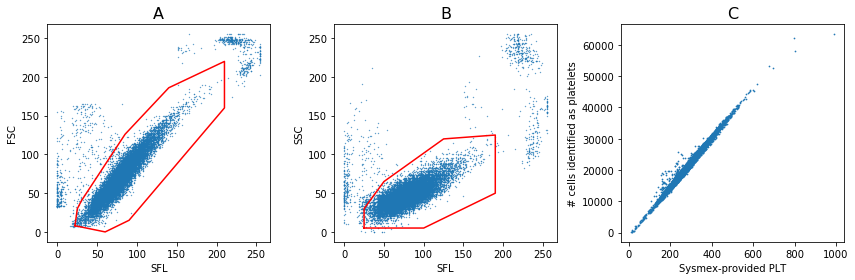

In [90]:
# Plot by cohort

fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(131)
cond3 = sys_sct.ID == sys_IDs[0]
plt.scatter(sys_sct.loc[cond3,"SFL"],sys_sct.loc[cond3,"FSC"],s=.1)
plt.plot(path_sfl_fsc._vertices[:,0],path_sfl_fsc._vertices[:,1],c="red")
ax.set_xlabel("SFL")
ax.set_ylabel("FSC")
ax.set_title("A",fontsize=16)

ax = fig.add_subplot(132)
cond3 = sys_sct.ID == sys_IDs[0]
plt.scatter(sys_sct.loc[cond3,"SFL"],sys_sct.loc[cond3,"SSC"],s=.1)
plt.plot(path_pfc._vertices[:,0],path_pfc._vertices[:,1],c="red")
ax.set_xlabel("SFL")
ax.set_ylabel("SSC")
ax.set_title("B",fontsize=16)

ax = fig.add_subplot(133)
#.title("Identifying cells on %d scattergrams" % PLT_count_compare.shape[0])
ax.set_ylabel("# cells identified as platelets")
ax.set_xlabel("Sysmex-provided PLT")
ax.scatter(PLT_count_compare.PLT,PLT_count_compare.PLT_gated,s=.5)#c=PLT_count_compare.index.isin(int_IDs)
ax.set_title("C",fontsize=16)

plt.tight_layout()
plt.savefig("/home/hv270/sysmex2pf/figures/gating.pdf")
print("$R^2 = %.4f$" % pearsonr(PLT_count_compare.PLT,PLT_count_compare.PLT_gated)[0]**2)

In [91]:
#SFL-FSC polygon
df_sfl_fsc = pd.DataFrame(data=path_sfl_fsc._vertices,columns=["SFL","FSC"])
df_sfl_fsc["pair"] = "(" + df_sfl_fsc["SFL"].astype(int).astype(str) + "," + df_sfl_fsc["FSC"].astype(int).astype(str) + ")"
df_sfl_fsc[["pair"]]

,pair
0,"(22,8)"
1,"(25,30)"
2,"(30,40)"
3,"(85,126)"
4,"(140,186)"
5,"(210,220)"
6,"(210,160)"
7,"(90,15)"
8,"(60,0)"
9,"(22,8)"


In [93]:
#SFL-FSC INT 41
df_sfl_fsc = pd.DataFrame(data=path_41._vertices,columns=["SFL","SSC"])
df_sfl_fsc["pair"] = "(" + df_sfl_fsc["SFL"].astype(int).astype(str) + "," + df_sfl_fsc["SSC"].astype(int).astype(str) + ")"
df_sfl_fsc[["pair"]]

,pair
0,"(15,5)"
1,"(15,45)"
2,"(125,125)"
3,"(190,130)"
4,"(190,50)"
5,"(100,5)"
6,"(15,5)"


 # Equalize the number of platelets across individuals

In [95]:
def sample(df):
    return df.sample(5000,replace=True)

In [96]:
PLT = PLT.groupby("ID").apply(sample)

In [97]:
PLT = PLT[FACS_COLS].reset_index()
del PLT["level_1"]

In [98]:
PLT.sample(2)

,ID,FSC,SSC,SFL
57889298,INT_116_3262200,125,42,97
153015097,INT_116_868600,76,49,98


In [99]:
PLT.shape[0] // int(1e6)

156

# Export unadjusted

In [101]:
PLT.to_hdf("%s/processed/PLT_unadjusted.hdf" % data_dir,key="PLT")

In [100]:
# What is below is not used anymore

# Make sub-cohorts in Sysmex cohort & check temporal correlation

In [31]:
sys_mean_values = PLT.loc[PLT.ID.isin(sys_plt.ID.unique().tolist())].groupby("ID")[FACS_COLS].mean()

In [59]:
#sys_phen = load_sys_phenotypes(data_dir)
sys_phen["time_col"] = pd.to_datetime(sys_phen["Date"].astype(str) + " " + sys_phen["Time"].astype(str),format="%d/%m/%Y %H:%M:%S")
sys_phen.sort_values(["time_col"],inplace=True)

In [60]:
sys_info = pd.merge(sys_mean_values,sys_phen.set_index("ID")[["time_col"]],left_index=True,right_index=True).sort_values("time_col")

In [61]:
sys_info = sys_info.sort_values("time_col")

In [62]:
sys_info_flat = sys_info.copy()

In [63]:
sys_info_flat[FACS_COLS] -= sys_info_flat[FACS_COLS].mean()
sys_info_flat[FACS_COLS] /= sys_info_flat[FACS_COLS].std()

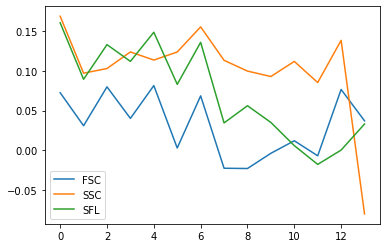

In [66]:
for c in FACS_COLS:
    deltas = [1,2,3,4,5,6,7,8,9,10,30,70,100,200]
    plt.plot(np.arange(len(deltas)),[np.mean(sys_info_flat[c].iloc[d:].values*sys_info_flat[c].iloc[:-d].values) for d in deltas],label=c)
plt.legend()

In [67]:
X = sys_info[FACS_COLS].values
X -= np.mean(X,axis=0)
X /= np.std(X,axis=0)

In [68]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=80).fit(
    X
)

5 BKPS


<Figure size 720x288 with 0 Axes>

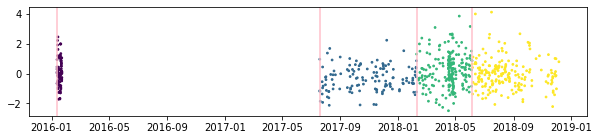

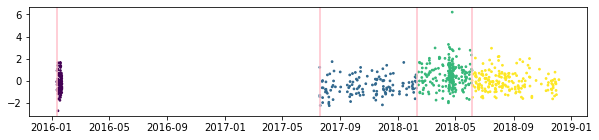

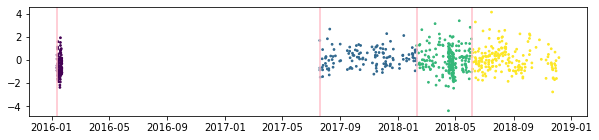

In [69]:
bkps = algo_c.predict(pen=2)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

sys_info["cohort"] = 0
sys_info["rank"] = np.arange(sys_info.shape[0])
for b in bkps[1:]:
    sys_info.loc[sys_info["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(sys_info["time_col"],X[:,i],s=3,c=sys_info.cohort)
    for b in bkps[:-1]:
        plt.axvline(sys_info["time_col"].iloc[b],c="pink")

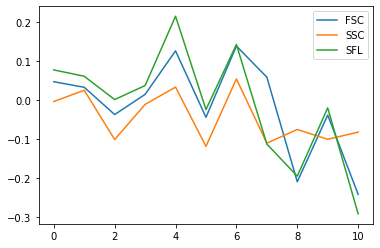

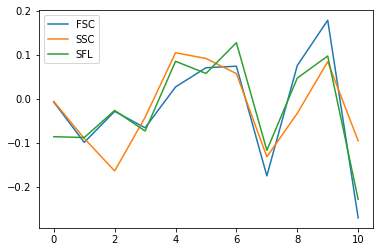

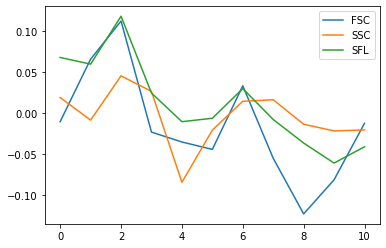

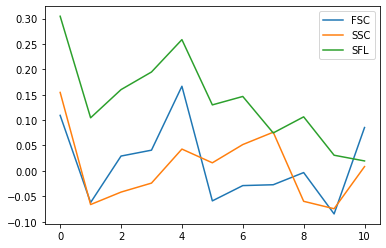

In [73]:
for cohort, sub_sys_info in sys_info.groupby("cohort"):
    sub_sys_info[FACS_COLS] -= sub_sys_info[FACS_COLS].mean()
    sub_sys_info[FACS_COLS] /= sub_sys_info[FACS_COLS].std()
    plt.figure()
    for c in FACS_COLS:
        deltas = [1,2,3,4,5,6,7,8,9,10,30]
        plt.plot(np.arange(len(deltas)),
                 [np.mean(sub_sys_info[c].iloc[d:].values*sub_sys_info[c].iloc[:-d].values) for d in deltas],label=c)
    plt.legend()

# Make sub-cohorts in Interval cohorts

In [43]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [44]:
int_mean_values = PLT.loc[PLT.ID.isin(int_plt.ID.unique().tolist())].groupby("ID")[FACS_COLS].mean()

30 BKPS
22 BKPS


<Figure size 720x288 with 0 Axes>

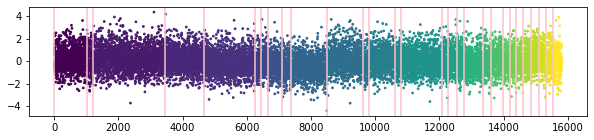

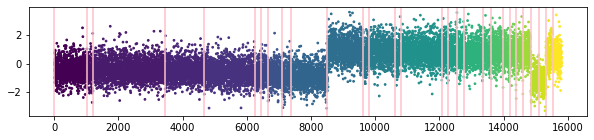

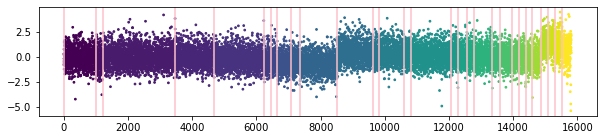

<Figure size 720x288 with 0 Axes>

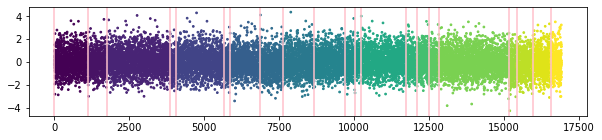

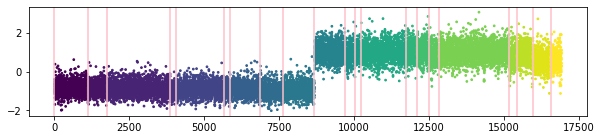

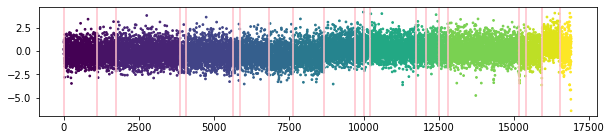

In [45]:
cohort_offset = sys_info.cohort.max() + 1
machines = int_phen["Instrument"].unique().tolist()
int_infos = []
for instrument in machines:
    int_info = pd.merge(int_mean_values, int_phen.loc[int_phen.Instrument == instrument,
                                                      ["SampleNo","DateTime"]],
                        left_index=True,right_on="SampleNo",how="inner")
    
    int_info.sort_values("DateTime",inplace=True)
    X = int_info[FACS_COLS].values
    X -= np.mean(X,axis=0)
    X /= np.std(X,axis=0)
    
    algo_c = rp.KernelCPD(kernel="rbf", min_size=200).fit(
        X
    )
    
    bkps = algo_c.predict(pen=1.6)
    bkps = [0] + bkps
    print("%d BKPS" % len(bkps))

    int_info["cohort"] = cohort_offset
    int_info["rank"] = np.arange(int_info.shape[0])
    for b in bkps[1:]:
        int_info.loc[int_info["rank"] >= b,"cohort"] += 1

    plt.figure(figsize=(10,4))
    for i in range(X.shape[1]):
        plt.figure(figsize=(10,2))
        plt.scatter(int_info["rank"],X[:,i],s=3,c=int_info.cohort)
        for b in bkps[:-1]:
            plt.axvline(int_info["rank"].iloc[b],c="pink")
    int_infos.append(int_info)
    cohort_offset = int_info.cohort.max() + 1
int_info = pd.concat(int_infos,axis=0)

In [46]:
int_info.head()

,FSC,SSC,SFL,SampleNo,DateTime,cohort,rank
0,56.8764,38.3952,75.1662,INT_116_6580100,2013-03-01 10:19:44,4,0
1,63.9528,44.0194,81.0894,INT_116_6580000,2013-03-01 10:21:00,4,1
2,57.2684,38.3992,78.5108,INT_116_4555900,2013-03-01 10:23:33,4,2
3,64.1398,44.2672,83.6544,INT_116_4555800,2013-03-01 10:24:49,4,3
4,55.8218,41.0774,77.2096,INT_116_4556000,2013-03-01 10:26:06,4,4


# Load age & sex

In [47]:
sys_agesex, int_agesex = get_ages_sex()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


# Gather all

In [48]:
sys_all = pd.merge(sys_agesex,sys_info,left_index=True,right_index=True,how="inner").sort_values("time_col")
sys_all.head()

,SEX,AGE,FSC,SSC,SFL,time_col,cohort,rank
C0WX14,2,67.0,66.3008,46.1298,78.1914,2016-01-12,0,0
C0WX4Z,2,63.0,71.5128,48.0916,79.3672,2016-01-12,0,1
C0WX6V,2,64.0,69.0480,47.7840,79.3124,2016-01-12,0,2
C0WX7T,2,70.0,71.3532,50.6206,84.0312,2016-01-12,0,3
C0WX8R,2,71.0,73.7594,47.5058,82.1168,2016-01-12,0,4


In [49]:
sys_all.tail()

,SEX,AGE,FSC,SSC,SFL,time_col,cohort,rank
C1A2PI,1,69.0,70.7326,47.5976,79.1384,2018-11-28,3,634
C1A2RE,1,60.0,74.7452,47.9168,81.8974,2018-11-29,3,635
C1A2TA,2,42.0,68.7200,45.6970,77.7288,2018-11-29,3,636
C1A2X2,1,71.0,62.4620,44.5052,73.2352,2018-11-30,3,637
C1A32N,2,44.0,73.5376,48.0428,83.0850,2018-12-05,3,638


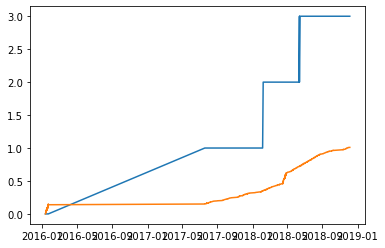

In [50]:
plt.plot(sys_all.time_col,sys_all.cohort)
plt.plot(sys_all.time_col,sys_all["rank"] / sys_all.shape[0])

In [51]:
int_all = pd.merge(int_agesex,int_info,left_index=True,right_on="SampleNo",how="inner").set_index("SampleNo").sort_values("DateTime")
int_all.head()

,SEX,AGE,FSC,SSC,SFL,DateTime,cohort,rank
SampleNo,,,,,,,,
INT_116_6580100,1,58.8,56.8764,38.3952,75.1662,2013-03-01 10:19:44,4,0
INT_116_6580000,2,22.6,63.9528,44.0194,81.0894,2013-03-01 10:21:00,4,1
INT_116_4555900,2,59.4,57.2684,38.3992,78.5108,2013-03-01 10:23:33,4,2
INT_116_4555800,2,21.3,64.1398,44.2672,83.6544,2013-03-01 10:24:49,4,3
INT_116_4556000,1,49.3,55.8218,41.0774,77.2096,2013-03-01 10:26:06,4,4


In [52]:
all_ = pd.concat((sys_all[["SEX","AGE","cohort"]+FACS_COLS],
                  int_all[["SEX","AGE","cohort"]+FACS_COLS]),axis=0)
X = pd.concat([all_[["SEX","AGE"]],pd.get_dummies(all_["cohort"],drop_first=True)],axis=1)
Y = all_[FACS_COLS]
# IT IS DEGENERATE IF WE DON'T DROP THE FIRST LEVEL

In [53]:
X.sample(3)

,SEX,AGE,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,53
INT_116_5489200,1,40.2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
INT_116_6638500,1,21.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
INT_116_616500,1,51.4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
Y.sample(3)

,FSC,SSC,SFL
INT_116_6702900,66.8678,47.2674,86.324
INT_116_5345000,51.4580,42.3286,77.931
INT_116_4887800,65.4348,31.3922,87.434


In [55]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)
cohort_coefs = lm.coef_[:,2:]
print(cohort_coefs.shape)

(3, 53)


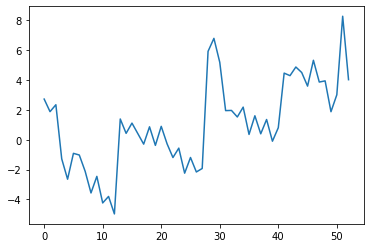

In [56]:
plt.plot(cohort_coefs[2])

In [57]:
## 
## WARNING 
## This actually changes the data

In [58]:
# Classic way, adjust just mean
for c in all_.cohort.unique().tolist():
    if c == 0: continue
    cohort_cond = PLT.ID.isin(all_.loc[all_.cohort == c].index.tolist())
    PLT.loc[cohort_cond,FACS_COLS] -= cohort_coefs[:,c-1]

In [59]:
PLT.to_hdf("%s/processed/PLT.hdf" % data_dir,key="PLT")

In [ ]:
# Wrote a new version of STD adjustment on, july 27th, not yet tested

In [96]:
ref_cohort_cond = PLT.ID.isin(all_.loc[all_.cohort == 0].index.tolist())
ref_std = PLT.loc[ref_cohort_cond].groupby("ID")[FACS_COLS].std().mean()

In [98]:
STD_adjusted_PLT = PLT.copy()

In [105]:
for c in all_.cohort.unique().tolist():
    cohort_cond = PLT.ID.isin(all_.loc[all_.cohort == c].index.tolist())
    GB = PLT.loc[cohort_cond].groupby("ID")[FACS_COLS]
    mean = GB.mean().mean()
    std = GB.std().mean()
    print(std)
    STD_adjusted_PLT.loc[cohort_cond,FACS_COLS] = PLT.loc[cohort_cond,FACS_COLS] * (ref_std / std)
    #print(STD_adjusted_PLT)
    #print(PLT.loc[cohort_cond].groupby("ID")[FACS_COLS].std().mean())

FSC    25.603862
SSC    13.795522
SFL    21.713086
dtype: float64
FSC    25.001998
SSC    13.485304
SFL    21.967183
dtype: float64
FSC    25.753134
SSC    14.369942
SFL    21.751704
dtype: float64
FSC    25.627649
SSC    14.038098
SFL    22.017023
dtype: float64
FSC    25.592178
SSC    15.713930
SFL    22.484631
dtype: float64
FSC    25.488802
SSC    12.025868
SFL    22.903432
dtype: float64
FSC    25.210661
SSC    15.568783
SFL    22.298936
dtype: float64
FSC    25.387482
SSC    12.016467
SFL    22.831373
dtype: float64
FSC    25.695662
SSC    15.818560
SFL    22.689242
dtype: float64
FSC    25.673147
SSC    12.040012
SFL    23.133957
dtype: float64
FSC    25.507315
SSC    15.743807
SFL    22.662308
dtype: float64
FSC    24.926236
SSC    11.635262
SFL    22.674756
dtype: float64
FSC    25.543462
SSC    11.925297
SFL    23.187890
dtype: float64
FSC    25.102560
SSC    15.444877
SFL    22.460395
dtype: float64
FSC    25.144362
SSC    11.755353
SFL    22.841331
dtype: float64
FSC    25.

In [100]:
mean_values = STD_adjusted_PLT.groupby("ID")[FACS_COLS].mean()

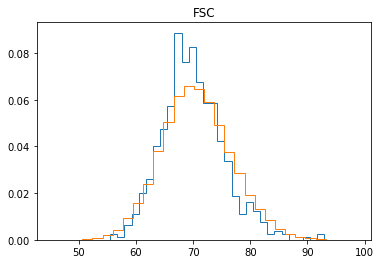

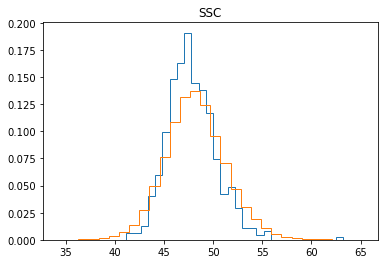

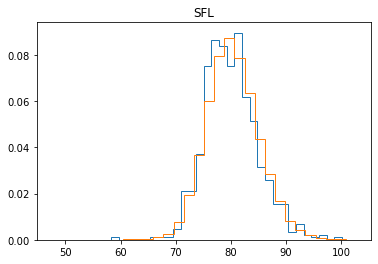

In [102]:
for c in FACS_COLS:
    plt.figure()
    plt.hist(mean_values.loc[mean_values.index.isin(sys_plt.ID.unique().tolist()),c],label="Sysmex Cohort",histtype="step",density=True,bins=30)
    plt.hist(mean_values.loc[~mean_values.index.isin(sys_plt.ID.unique().tolist()),c],label="INTERVAL Cohort",histtype="step",density=True,bins=30)
    plt.title(c)

In [104]:
STD_adjusted_PLT.to_hdf("%s/processed/PLT.hdf" % data_dir,key="PLT")

In [92]:
# Adjust STD ?